In [1]:
## Import Dependencies

from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import datetime as dt
import time
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy import optimize
from matplotlib.dates import (MONTHLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

In [2]:
#Read in the power data for DP&L
df = pd.read_csv('DPL_Hourly_Consumption.csv',parse_dates =['Datetime'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
Datetime     121275 non-null datetime64[ns]
DAYTON_MW    121275 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 MB


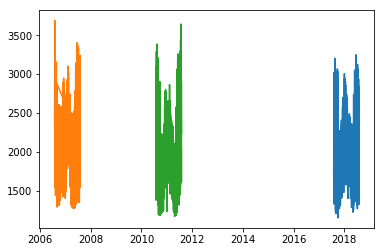

In [4]:
## some simple plots to visualize the data

x = df[(df.Datetime> "2017-08-01") & (df.Datetime <= '2018-08-01')].Datetime
y = df[(df.Datetime> "2017-08-01") & (df.Datetime <= '2018-08-01')].DAYTON_MW
x2 = df[(df.Datetime> "2006-08-01") & (df.Datetime <= '2007-08-01')].Datetime
y2 = df[(df.Datetime> "2006-08-01") & (df.Datetime <= '2007-08-01')].DAYTON_MW
x3 = df[(df.Datetime> "2010-08-01") & (df.Datetime <= '2011-08-01')].Datetime
y3 = df[(df.Datetime> "2010-08-01") & (df.Datetime <= '2011-08-01')].DAYTON_MW
plt.plot(x,y)
plt.plot(x2,y2)
plt.plot(x3,y3)

plt.show()



In [5]:
# Read in Weather Data

Wd = pd.read_json("weather_data_json_dayton_bulkText.json")

In [6]:
Wd.head()
Wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42169 entries, 0 to 42168
Data columns (total 9 columns):
city_id    42169 non-null int64
clouds     42169 non-null object
dt         42169 non-null int64
dt_iso     42169 non-null object
main       42169 non-null object
rain       6327 non-null object
snow       46 non-null object
weather    42169 non-null object
wind       42169 non-null object
dtypes: int64(2), object(7)
memory usage: 2.9+ MB


In [7]:
## Cleaner way to pull this in as datetime.. create column and use the lambda to get rid of the extra UTC datetime data
Wd['Date_Clean'] = (Wd['dt_iso'].apply(lambda x: x[:19])
                    .apply(lambda x : dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
                   )

In [8]:
# because we are going to make use of the dates in our analysis .. rows for month year, day, day of week, and weekend are created. 

Wd2 = Wd.assign(year = Wd['Date_Clean'].dt.year,
         month = Wd['Date_Clean'].dt.month,
         day = Wd['Date_Clean'].dt.day,
         day_of_week = Wd['Date_Clean'].dt.weekday,
         weekend = Wd['Date_Clean'].dt.weekday.apply(lambda x : 1 if x > 4 else 0)).copy()
Wd2.head()

,city_id,clouds,dt,dt_iso,main,rain,snow,weather,wind,Date_Clean,year,month,day,day_of_week,weekend
0,4509884,{'all': 75},1349096400,2012-10-01 13:00:00 +0000 UTC,"{'temp': 284.02, 'temp_min': 282.15, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 2, 'deg': 30}",2012-10-01 13:00:00,2012,10,1,0,0
1,4509884,{'all': 75},1349100000,2012-10-01 14:00:00 +0000 UTC,"{'temp': 285.83, 'temp_min': 284.26, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 2, 'deg': 50}",2012-10-01 14:00:00,2012,10,1,0,0
2,4509884,{'all': 75},1349190000,2012-10-02 15:00:00 +0000 UTC,"{'temp': 287.44, 'temp_min': 286.48, 'temp_max...",NaN,NaN,"[{'id': 803, 'main': 'Clouds', 'description': ...","{'speed': 3, 'deg': 90}",2012-10-02 15:00:00,2012,10,2,1,0
3,4509884,{'all': 1},1349193600,2012-10-02 16:00:00 +0000 UTC,"{'temp': 288.31, 'temp_min': 287.15, 'temp_max...",NaN,NaN,"[{'id': 800, 'main': 'Clear', 'description': '...","{'speed': 3, 'deg': 70}",2012-10-02 16:00:00,2012,10,2,1,0
4,4509884,{'all': 40},1349197200,2012-10-02 17:00:00 +0000 UTC,"{'temp': 289.5, 'temp_min': 288.71, 'temp_max'...",NaN,NaN,"[{'id': 802, 'main': 'Clouds', 'description': ...","{'speed': 4, 'deg': 80}",2012-10-02 17:00:00,2012,10,2,1,0


In [9]:
# We have some conversions to do as some of the columns are dicts, and units are not suitable

Temp = []
Humidity = []
Wind = []
Date_Time = []
Rain = []
Month = []
Snow = []
Year = []
Day = []
Day_of_Week = []
Weekend = []

for i in range(0,len(Wd2)):
    #Convert to Fahrenheit
    t = round(((Wd2.main[i]['temp_max']-273.15)*9/5)+32,2)
    h = Wd2.main[i]['humidity']
    #Convert to MPH
    w = round(Wd2.wind[i]['speed']*2.26394,2)
    d = Wd2['Date_Clean'][i]
    r = Wd2.rain[i]
    s = Wd2.snow[i]
    m = Wd2.month[i]
    y = Wd2.year[i]
    dy = Wd2.day[i]
    dow =Wd2.day_of_week[i]
    wknd = Wd2.weekend[i]
    Rain.append(r)
    Snow.append(s)
    Date_Time.append(d)
    Wind.append(w)
    Humidity.append(h)
    Temp.append(t)
    Month.append(m)
    Year.append(y)
    Day.append(dy)
    Day_of_Week.append(dow)
    Weekend.append(wknd)

    
# now we have a group of lists 


In [10]:
#Next build dictionary to reassemble our DF
Wd_dict = {'City':"Dayton,OH",'Datetime':Date_Time,"Year":Year,'Month':Month,'Day':Day,'Day_of_Week':Day_of_Week,'Weekend':Weekend,'Temperature(F)':Temp,
          'Humidity':Humidity,'Wind Speed(mph)':Wind,'Rain Volume':Rain,'Snow Volume':Snow,}
Wd_df = pd.DataFrame(Wd_dict)

In [11]:
Wd_df.head()


,City,Datetime,Year,Month,Day,Day_of_Week,Weekend,Temperature(F),Humidity,Wind Speed(mph),Rain Volume,Snow Volume
0,"Dayton,OH",2012-10-01 13:00:00,2012,10,1,0,0,54.00,81,4.53,NaN,NaN
1,"Dayton,OH",2012-10-01 14:00:00,2012,10,1,0,0,57.99,76,4.53,NaN,NaN
2,"Dayton,OH",2012-10-02 15:00:00,2012,10,2,1,0,59.00,62,6.79,NaN,NaN
3,"Dayton,OH",2012-10-02 16:00:00,2012,10,2,1,0,62.01,77,6.79,NaN,NaN
4,"Dayton,OH",2012-10-02 17:00:00,2012,10,2,1,0,63.00,72,9.06,NaN,NaN


In [12]:
## calling info we confirm we have a datetime object for Datetime
Wd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42169 entries, 0 to 42168
Data columns (total 12 columns):
City               42169 non-null object
Datetime           42169 non-null datetime64[ns]
Year               42169 non-null int64
Month              42169 non-null int64
Day                42169 non-null int64
Day_of_Week        42169 non-null int64
Weekend            42169 non-null int64
Temperature(F)     42169 non-null float64
Humidity           42169 non-null int64
Wind Speed(mph)    42169 non-null float64
Rain Volume        6327 non-null object
Snow Volume        46 non-null object
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 3.9+ MB


In [13]:
## ok now ready we agreed to use more recent data for our dataset so will grab data from May1 of 2016 thru April 30 2018.
df.Datetime.head(24)

df_2 = df[(df.Datetime>='2016-05-01 00:00:00') & (df.Datetime< '2018-05-01 00:00:00')].copy()
df_2.set_index('Datetime',inplace = True)
df_2



,DAYTON_MW
Datetime,
2016-12-31 01:00:00,1788
2016-12-31 02:00:00,1730
2016-12-31 03:00:00,1701
2016-12-31 04:00:00,1693
2016-12-31 05:00:00,1708
2016-12-31 06:00:00,1732
2016-12-31 07:00:00,1778
2016-12-31 08:00:00,1849
2016-12-31 09:00:00,1877


In [14]:
## lets take a look at the len
len(df_2)


17520

In [15]:
## so the Weather Df we create should be of the same length

Wd_df_2 = Wd_df[(Wd_df.Datetime>='2016-05-01 00:00:00') & (Wd_df.Datetime< '2018-05-01 00:00:00')].copy()
Wd_df_2.set_index('Datetime',inplace = True)
Wd_df_2

,City,Year,Month,Day,Day_of_Week,Weekend,Temperature(F),Humidity,Wind Speed(mph),Rain Volume,Snow Volume
Datetime,,,,,,,,,,,
2016-05-01 00:00:00,"Dayton,OH",2016,5,1,6,1,59.00,100,4.53,{'1h': 1.1},NaN
2016-05-01 01:00:00,"Dayton,OH",2016,5,1,6,1,59.00,100,9.06,{'1h': 0.76},NaN
2016-05-01 02:00:00,"Dayton,OH",2016,5,1,6,1,59.00,87,9.06,{'1h': 0.51},NaN
2016-05-01 03:00:00,"Dayton,OH",2016,5,1,6,1,59.00,93,9.06,{'1h': 0.25},NaN
2016-05-01 04:00:00,"Dayton,OH",2016,5,1,6,1,60.80,100,4.53,{'1h': 0.25},NaN
2016-05-01 05:00:00,"Dayton,OH",2016,5,1,6,1,60.80,100,6.79,{'1h': 0.25},NaN
2016-05-01 06:00:00,"Dayton,OH",2016,5,1,6,1,61.00,87,6.79,{'1h': 0.25},NaN
2016-05-01 07:00:00,"Dayton,OH",2016,5,1,6,1,61.00,100,6.79,{'1h': 0.42},NaN
2016-05-01 08:00:00,"Dayton,OH",2016,5,1,6,1,61.00,100,6.79,{'1h': 0.25},NaN


In [16]:
### so it seems we have some missing values in the weather data this will mean some times 76 hours where we will not get a 
## match on the join.

combined_df = df_2.join(Wd_df_2,how = 'left')
combined_df.drop(index = combined_df[combined_df.City.isna()].index.values,inplace = True)


In [17]:
combined_df

,DAYTON_MW,City,Year,Month,Day,Day_of_Week,Weekend,Temperature(F),Humidity,Wind Speed(mph),Rain Volume,Snow Volume
Datetime,,,,,,,,,,,,
2016-05-01 00:00:00,1473,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,59.00,100.0,4.53,{'1h': 1.1},NaN
2016-05-01 01:00:00,1392,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,59.00,100.0,9.06,{'1h': 0.76},NaN
2016-05-01 02:00:00,1337,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,59.00,87.0,9.06,{'1h': 0.51},NaN
2016-05-01 03:00:00,1301,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,59.00,93.0,9.06,{'1h': 0.25},NaN
2016-05-01 04:00:00,1273,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,60.80,100.0,4.53,{'1h': 0.25},NaN
2016-05-01 05:00:00,1279,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,60.80,100.0,6.79,{'1h': 0.25},NaN
2016-05-01 06:00:00,1297,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,61.00,87.0,6.79,{'1h': 0.25},NaN
2016-05-01 07:00:00,1332,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,61.00,100.0,6.79,{'1h': 0.42},NaN
2016-05-01 08:00:00,1375,"Dayton,OH",2016.0,5.0,1.0,6.0,1.0,61.00,100.0,6.79,{'1h': 0.25},NaN


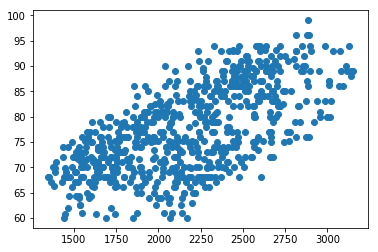

Datetime
2016-06-01 00:00:00    84.20
2016-06-01 01:00:00    81.00
2016-06-01 02:00:00    78.80
2016-06-01 03:00:00    75.99
2016-06-01 04:00:00    73.99
2016-06-01 05:00:00    73.40
2016-06-01 06:00:00    72.00
2016-06-01 07:00:00    72.00
2016-06-01 08:00:00    71.01
2016-06-01 09:00:00    70.00
2016-06-01 10:00:00    68.00
2016-06-01 11:00:00    68.00
2016-06-01 12:00:00    75.99
2016-06-01 13:00:00    82.00
2016-06-01 15:00:00    89.01
2016-06-01 15:00:00    90.00
2016-06-01 16:00:00    91.99
2016-06-01 17:00:00    93.99
2016-06-01 19:00:00    93.99
2016-06-01 19:00:00    91.99
2016-06-01 20:00:00    89.60
2016-06-01 21:00:00    87.80
2016-06-01 23:00:00    87.80
2016-06-01 23:00:00    87.01
2016-06-02 00:00:00    78.80
2016-06-02 01:00:00    75.20
2016-06-02 02:00:00    73.00
2016-06-02 03:00:00    71.60
2016-06-02 04:00:00    70.00
2016-06-02 05:00:00    70.00
                       ...  
2016-06-29 14:00:00    71.01
2016-06-29 15:00:00    73.99
2016-06-29 16:00:00    73.00
2016-

In [18]:
y= combined_df[(combined_df["Temperature(F)"]> 60)&(combined_df.Year == 2016) & (combined_df.Month==6)]['Temperature(F)']
x= combined_df[(combined_df["Temperature(F)"]>60)&(combined_df.Year == 2016) & (combined_df.Month==6)]['DAYTON_MW']
x2 =combined_df.iloc[150:]['Humidity']
plt.scatter(x,y)

plt.show()
np.cov(x.values,y.values)[0,1]
#x.values
y

In [19]:

First_Week_df = combined_df[(combined_df.index >= '2016-07-01') & (combined_df.index < '2016-07-02')]
June = combined_df
FWmean = round(First_Week_df['Temperature(F)'].mean(),2)
FWstd = round(First_Week_df["Temperature(F)"].std(),2)
FWsem = round(First_Week_df["Temperature(F)"].sem(),2)
FWsem
First_Week_df['DAYTON_MW'].mean()
First_Week_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2016-07-01 00:00:00 to 2016-07-01 23:00:00
Data columns (total 12 columns):
DAYTON_MW          24 non-null int64
City               24 non-null object
Year               24 non-null float64
Month              24 non-null float64
Day                24 non-null float64
Day_of_Week        24 non-null float64
Weekend            24 non-null float64
Temperature(F)     24 non-null float64
Humidity           24 non-null float64
Wind Speed(mph)    24 non-null float64
Rain Volume        5 non-null object
Snow Volume        0 non-null object
dtypes: float64(8), int64(1), object(3)
memory usage: 2.4+ KB


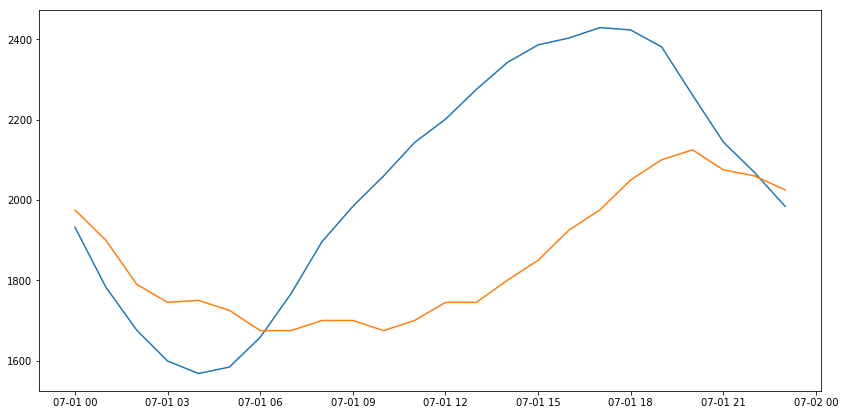

In [20]:
plt.figure(figsize=[14,7])

x = First_Week_df.index   #['Temperature(F)']
y = First_Week_df["DAYTON_MW"]
y2 = First_Week_df['Temperature(F)']*25
#plt.xlim("2016-05-01","2016-05-08")
plt.plot(x,y)
plt.plot(x,y2)

In [21]:
# making new dataframes for each day
mondays = (combined_df.Day_of_Week == 0.0)
tuesdays = (combined_df.Day_of_Week == 1.0)
wednesdays = (combined_df.Day_of_Week == 2.0)
thursdays = (combined_df.Day_of_Week == 3.0)
fridays = (combined_df.Day_of_Week == 4.0)
saturdays = (combined_df.Day_of_Week == 5.0)
sundays = (combined_df.Day_of_Week == 6.0)

mondays_df = combined_df[mondays]
tuesdays_df = combined_df[tuesdays]
wednesdays_df = combined_df[wednesdays]
thursdays_df = combined_df[thursdays]
fridays_df = combined_df[fridays]
saturdays_df = combined_df[saturdays]
sundays_df = combined_df[sundays]



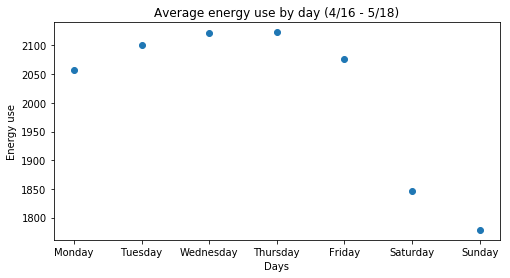

In [31]:
#to start, an overview graph of the average energy costs for each day
means = [mondays_df.DAYTON_MW.mean(), tuesdays_df.DAYTON_MW.mean(),
         wednesdays_df.DAYTON_MW.mean(),thursdays_df.DAYTON_MW.mean(),
         fridays_df.DAYTON_MW.mean(), saturdays_df.DAYTON_MW.mean(), 
         sundays_df.DAYTON_MW.mean()]
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fig_a = plt.figure(figsize=[8,4])
x = days
y = means
plt.xlabel("Days")
plt.ylabel("Energy use")
plt.title("Average energy use by day (4/16 - 5/18)")
days_mean_plt = plt.scatter(x,y)
plt.savefig('seven_days.png', bbox_inches='tight')
plt.show()


In [23]:
day_energy_df = combined_df.groupby(["Day_of_Week","Year","Month","Day"]).mean()

In [24]:
mon_group = mondays_df.groupby(["Year","Month","Day"])
mon_avg = mon_group["DAYTON_MW"].mean()

tues_group = tuesdays_df.groupby(["Year","Month","Day"])
tues_avg = tues_group["DAYTON_MW"].mean()

weds_group = wednesdays_df.groupby(["Year","Month","Day"])
weds_avg = weds_group["DAYTON_MW"].mean()

thurs_group = thursdays_df.groupby(["Year","Month","Day"])
thurs_avg = thurs_group["DAYTON_MW"].mean()

fri_group = fridays_df.groupby(["Year","Month","Day"])
fri_avg = fri_group["DAYTON_MW"].mean()

sat_group = saturdays_df.groupby(["Year","Month","Day"])
sat_avg = sat_group["DAYTON_MW"].mean()

sun_group = sundays_df.groupby(["Year","Month","Day"])
sun_avg = sun_group["DAYTON_MW"].mean()

m_ = range(len(mon_avg))
t_ = range(len(tues_avg))
w_ = range(len(weds_avg))
th_ = range(len(thurs_avg))
f_ = range(len(fri_avg))
s_ = range(len(sat_avg))
su_ = range(len(sun_avg))

In [25]:
#making new dictionaries to turn into dfs so we can more easily use seaborn
dict0 = {'Mondays': m_,'Energy Use':mon_avg}
dict1 = {'Tuesdays': t_,'Energy Use':tues_avg}
dict2 = {'Wednesdays': w_,'Energy Use':weds_avg}
dict3 = {'Thursdays': th_,'Energy Use':thurs_avg}
dict4 = {'Fridays': f_,'Energy Use':fri_avg}
dict5 = {'Saturdays': s_,'Energy Use':sat_avg}
dict6 = {'Sundays': su_,'Energy Use':sun_avg}

mon_df = pd.DataFrame(dict0)
tues_df = pd.DataFrame(dict1)
weds_df = pd.DataFrame(dict2)
thurs_df = pd.DataFrame(dict3)
fri_df = pd.DataFrame(dict4)
sat_df = pd.DataFrame(dict5)
sun_df = pd.DataFrame(dict6)

C:\Users\pcons\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


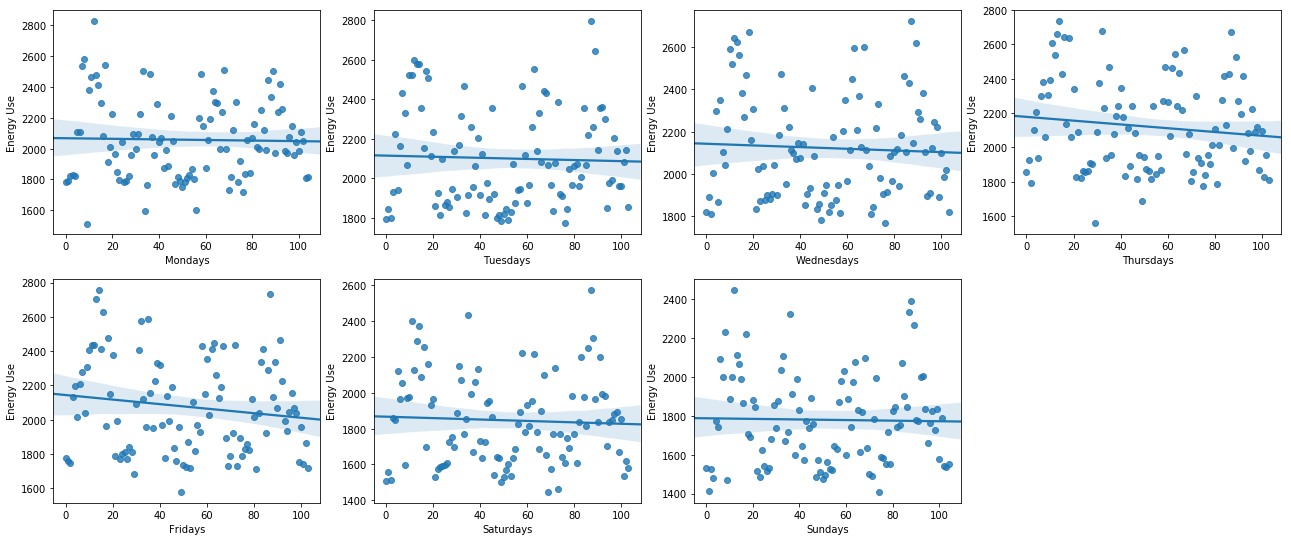

In [26]:
#over our dataset of 2 years, there are ~100 of each day of the week
plt.subplots(figsize=(22,14))

plt.subplot(341)

mon_final = sns.regplot(x='Mondays',y="Energy Use", data=mon_df)
plt.subplot(342)

tues_final = sns.regplot(x='Tuesdays',y="Energy Use", data=tues_df)
plt.subplot(343)

weds_final = sns.regplot(x='Wednesdays',y="Energy Use", data=weds_df)
plt.subplot(344)

thurs_final = sns.regplot(x='Thursdays',y="Energy Use", data=thurs_df)
plt.subplot(345)

fri_final = sns.regplot(x='Fridays',y="Energy Use", data=fri_df)
plt.subplot(346)

sat_final = sns.regplot(x='Saturdays',y="Energy Use", data=sat_df)
plt.subplot(347)
sun_final = sns.regplot(x='Sundays',y="Energy Use", data=sun_df)

plt.savefig('seven_days_seven_plots.png', bbox_inches='tight')


C:\Users\pcons\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


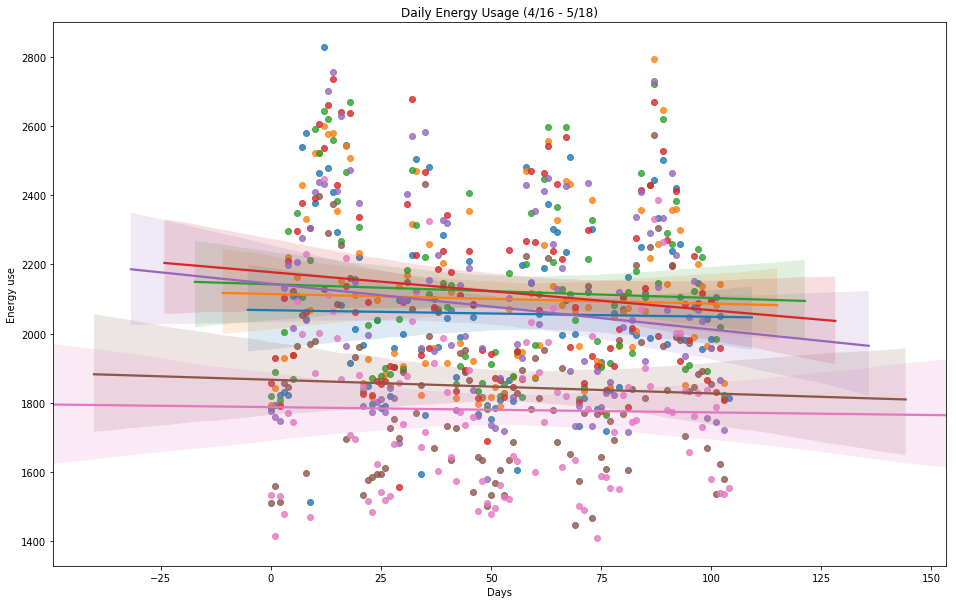

In [32]:
fig = plt.subplots(figsize=(16,10))

plt.title("Daily Energy Usage (4/16 - 5/18)")
mon_final = sns.regplot(x='Mondays',y="Energy Use", data=mon_df)
tues_final = sns.regplot(x='Tuesdays',y="Energy Use", data=tues_df)
weds_final = sns.regplot(x='Wednesdays',y="Energy Use", data=weds_df)
thurs_final = sns.regplot(x='Thursdays',y="Energy Use", data=thurs_df)
fri_final = sns.regplot(x='Fridays',y="Energy Use", data=fri_df)
sat_final = sns.regplot(x='Saturdays',y="Energy Use", data=sat_df)
sun_final = sns.regplot(x='Sundays',y="Energy Use", data=sun_df)
plt.xlabel("Days")
plt.ylabel("Energy use")

plt.savefig('seven_days_one_plot.png', bbox_inches='tight')
plt.show()